In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# ------------------------
# Settings
# ------------------------
d = 50                # base number of features (large for Gaussian approx)
sigma2 = 1.0
theta_s = 1.5         # effect size under H1
c_by_r = 0.15
# simulation sizes
n_calib = 2000        # sims to calibrate null per n (must be reasonably large)
n_eval = 1000         # sims to estimate type-I / power per n
alpha_values = np.array([0.00, 0.01, 0.02, 0.05, 0.10, 0.15, 0.2, 0.5, 1.0])
n=51

# helper: log pdf under Gaussian approx for Q = RSS/n
def log_gaussian_pdf(x, mu, var):
    return -0.5 * np.log(2 * np.pi * var) - (x - mu)**2 / (2 * var)

def compute_logLR_for_one(n, use_sensitive):
    """Simulate one dataset and return logL_d - logL_d1 (logLR)."""
    X_d = np.random.randn(n, d)
    sensitive = np.random.randn(n, 1)
    X_d1 = np.hstack([X_d, sensitive])

    theta_d = np.random.randn(d)
    theta_d1 = np.hstack([theta_d, theta_s])

    eps = np.random.randn(n) * np.sqrt(sigma2)
    if use_sensitive:
        y = X_d1 @ theta_d1 + eps
    else:
        y = X_d @ theta_d + eps

    # Fit OLS without sensitive attribute
    theta_hat_d = np.linalg.lstsq(X_d, y, rcond=None)[0]
    residuals_d = y - X_d @ theta_hat_d
    Q_obs = (residuals_d.T @ residuals_d) / n

    # Gaussian approx params
    mu_d = sigma2 * d / n
    var_d = 2 * sigma2**2 * d / n**2
    mu_d1 = sigma2 * (d + 1) / n
    var_d1 = 2 * sigma2**2 * (d + 1) / n**2

    logL_d = log_gaussian_pdf(Q_obs, mu_d, var_d)
    logL_d1 = log_gaussian_pdf(Q_obs, mu_d1, var_d1)
    logLR = logL_d - logL_d1
    return float(logLR)

# ------------------------
# Calibration + evaluation
# ------------------------
type1_list = []
power_list = []

for alpha in alpha_values:
    # --- calibrate null distribution of logLR ---
    null_logLRs = np.empty(n_calib)
    for i in range(n_calib):
        null_logLRs[i] = compute_logLR_for_one(n, use_sensitive=False)
    crit = np.quantile(null_logLRs, alpha)   # reject H0 when logLR <= crit

    # sanity: estimate empirical type-I with fresh sims
    null_test_logLRs = np.empty(n_eval)
    for i in range(n_eval):
        null_test_logLRs[i] = compute_logLR_for_one(n, use_sensitive=False)
    type1_emp = np.mean(null_test_logLRs <= crit)

    # estimate power with fresh sims under H1
    alt_logLRs = np.empty(n_eval)
    for i in range(n_eval):
        alt_logLRs[i] = compute_logLR_for_one(n, use_sensitive=True)
    power_emp = np.mean(alt_logLRs <= crit)

    type1_list.append(type1_emp)
    power_list.append(power_emp)
    print(f"alpha={alpha:4f}  crit={crit:7.3f}  type-I={type1_emp:.3f}  power={power_emp:.3f}")



alpha=0.000000  crit=  0.251  type-I=0.002  power=0.074
alpha=0.010000  crit=  0.254  type-I=0.006  power=0.132
alpha=0.020000  crit=  0.257  type-I=0.012  power=0.184
alpha=0.050000  crit=  0.259  type-I=0.045  power=0.285
alpha=0.100000  crit=  0.259  type-I=0.092  power=0.356
alpha=0.150000  crit=  0.260  type-I=0.140  power=0.421
alpha=0.200000  crit=  0.260  type-I=0.194  power=0.471
alpha=0.500000  crit=  0.260  type-I=0.505  power=0.699
alpha=1.000000  crit=  0.260  type-I=1.000  power=1.000


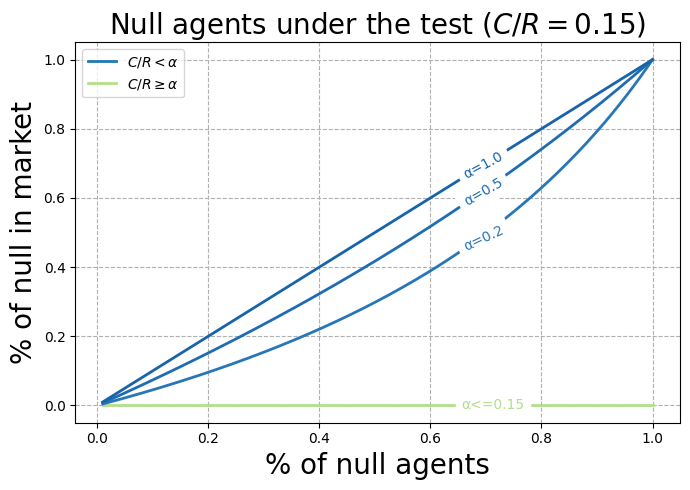

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# K ranges between 0 and 1
K = np.linspace(0.01, 1, 300)

# Different alpha values
powers = power_list
rotations= [25, 25, 30, 28, 28, 35]
# Color map for shades of blue
colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(alpha_values)))
incentive_flag = True
# Plot
fig, ax = plt.subplots(figsize=(7,5))

for i, alpha in enumerate(alpha_values):
    if alpha < c_by_r:
        if incentive_flag:
            ax.plot(K, 0*K, color='#b2df8a', linewidth=2, label=r'$C/R \geq \alpha$')
            incentive_flag = False
        else: continue
    elif alpha == c_by_r:
        # y_incentivized line
        idx = int(len(K) * 0.65)  # choose a point at 70% along x-axis
        ax.text(K[idx], -0.01, f'α<={alpha}', color='#b2df8a',backgroundcolor='white', fontsize=10)
        count = i
    else:
        y = (alpha_values[i] * K) / ((1-K)*powers[i] + alpha_values[i]*K)
        line, = ax.plot(K, y, color=colors[i], linewidth=2)
        # Annotate alpha on the line
        idx = int(len(K) * 0.65)  # choose a point at 70% along x-axis
        ax.text(K[idx], y[idx]+0.001, f'α={alpha}', color=colors[i],  rotation=rotations[i-count],backgroundcolor='white', fontsize=10)

# Labels and title
ax.set_xlabel(r'% of null agents', fontsize=20)
ax.set_ylabel(r'% of null in market', fontsize=20)
ax.set_title(r'Null agents under the test $(C/R=0.15)$', fontsize=20)

# Grid and legend
ax.grid(True, linestyle='--')

# Create a custom legend for the blue lines
from matplotlib.lines import Line2D
blue_line = Line2D([0], [0], color='#1f78b4', linewidth=2, label=r'$C/R < \alpha$')
ax.legend(handles=[blue_line, ax.lines[0]])
plt.tight_layout()
plt.savefig("null.pdf", format="pdf", bbox_inches='tight')
plt.show()

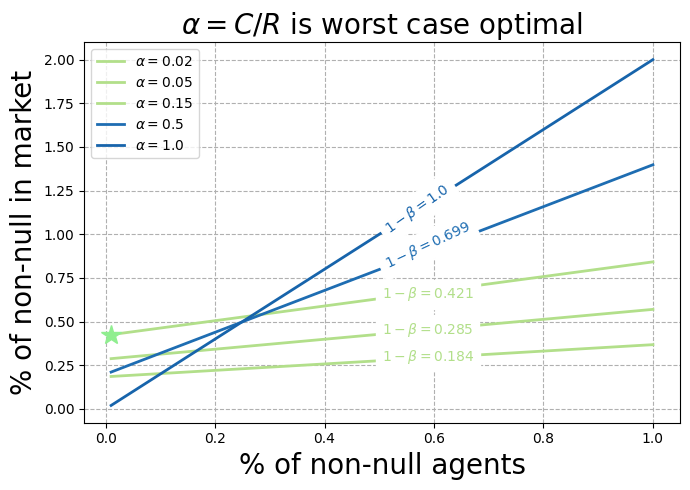

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# K ranges between 0 and 1
K = np.linspace(0.01, 1, 3)

# Different alpha values
rotations= [35, 35, 35, 35,35, 35, 30, 28, 28, 35]
# Color map for shades of blue
colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(alpha_values)))
# Plot
fig, ax = plt.subplots(figsize=(7,5))

for i, alpha in enumerate(alpha_values):
    if alpha in [0.1, 0.2]:
        continue
    #print(alpha, powers[i])
    approved_non_null = np.array([])
    participants = np.array([])
    if powers[i] >= c_by_r:
        approved_non_null = powers[i]*K
        participants = powers[i]*K
    if alpha > c_by_r:
        participants=approved_non_null - alpha*(1-K) # null agents participates because now it makes sense
    #print("participants:", participants)
    #print("approved_non_null:", approved_non_null)
    if np.size(participants)>0:
        y = participants
        #print("y:",y)
        if alpha <= c_by_r:
            color='#b2df8a'
        else:
            color = colors[i]
        if alpha == 1.0: 
            rotation = 35
        elif alpha == 0.5:
            rotation = 25
        else: 
            rotation = 0 
        line, = ax.plot(K, y+powers[i], color=color, linewidth=2, label=r'$\alpha=$' + f'{alpha}')
        idx = int(len(K) * 0.5)  # choose a point at 70% along x-axis
        ax.text(K[idx], y[idx]+powers[i], r'$1-\beta=$'+f'{powers[i]}', color=color, rotation = rotation, backgroundcolor='white', fontsize=10)

ax.plot(0.01, 0.421, marker='*', color='lightgreen', markersize=15)
# Labels and title
ax.set_xlabel(r'% of non-null agents', fontsize=20)
ax.set_ylabel(r'% of non-null in market', fontsize=20)
ax.set_title(r'$\alpha=C/R$ is worst case optimal', fontsize=20)

# Grid and legend
ax.grid(True, linestyle='--')

ax.legend()

plt.tight_layout()
plt.savefig("non_null.pdf", format="pdf", bbox_inches='tight')
plt.show()

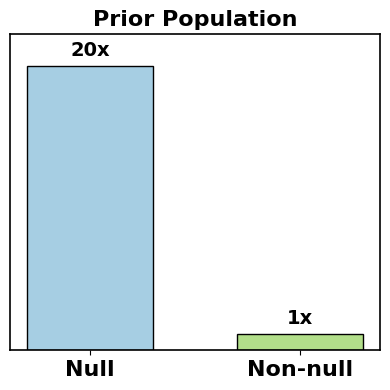

In [92]:
import matplotlib.pyplot as plt

# Data
categories = ['Null', 'Non-null']
heights = [0.9, 0.05]
colors = ['#a6cee3','#b2df8a']
labels = ['20x', '1x']

# Create plot
fig, ax = plt.subplots(figsize=(4, 4))  # square plot

# Draw bars
bars = ax.bar(categories, heights, color=colors, width=0.6, edgecolor='black')

# Annotate bars
for bar, label in zip(bars, labels):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            label, ha='center', va='bottom', fontsize=14, fontweight='bold')

# Style adjustments
ax.set_ylim(0, 1)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_title('Prior Population', fontsize=16, fontweight='bold')

# Make x-axis labels bold and larger
ax.tick_params(axis='x', labelsize=16)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Draw complete box around plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color('black')

plt.tight_layout()
plt.savefig("prior.pdf", format="pdf", bbox_inches='tight')
plt.show()

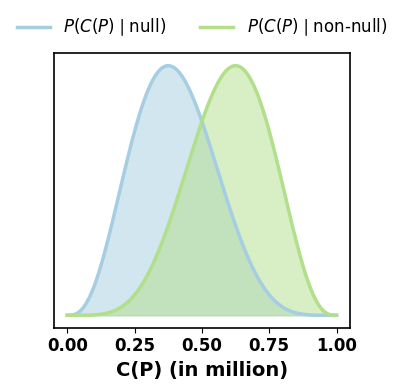

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Create x values
x = np.linspace(0, 1, 500)

# Define two beta distributions
# Null: mode ~0.7 -> parameters a=7, b=3
# Non-null: mode ~0.3 -> parameters a=3, b=7
y_null = beta.pdf(x, 4, 6)
y_nonnull = beta.pdf(x, 6, 4) 

# Colors
color_null = '#a6cee3'   # blueish
color_nonnull = '#b2df8a' # greenish

# Create square plot
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the two beta distributions
ax.plot(x, y_null, color=color_null, linewidth=2.5, label=r'$P(C(P)\mid\text{null})$')
ax.plot(x, y_nonnull, color=color_nonnull, linewidth=2.5, label=r'$P(C(P)\mid\text{non-null})$')

# Fill under the curves
ax.fill_between(x, y_null, color=color_null, alpha=0.5)
ax.fill_between(x, y_nonnull, color=color_nonnull, alpha=0.5)

# Labels
ax.set_xlabel('C(P) (in million)', fontsize=14, fontweight='bold')
ax.set_ylabel('')
ax.set_yticks([])
# Style axes
ax.tick_params(axis='both', labelsize=12)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# Draw complete box around plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color('black')

# Legend placed above the plot, side by side
ax.legend(fontsize=12, frameon=False, loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2)

plt.tight_layout()
plt.savefig("costs.pdf", format="pdf", bbox_inches='tight')
plt.show()

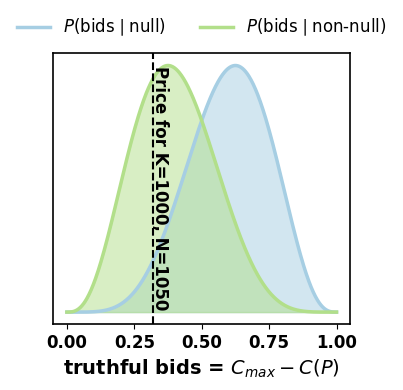

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Create x values
x = np.linspace(0, 1, 500)

# Define two beta distributions with swapped modes
y_null = beta.pdf(x, 6, 4)
y_nonnull = beta.pdf(x, 4, 6)

# Colors
color_null = '#a6cee3'   # blueish
color_nonnull = '#b2df8a' # greenish

# Create square plot
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the two beta distributions
ax.plot(x, y_null, color=color_null, linewidth=2.5, label=r'$P(\text{bids} \mid \text{null})$')
ax.plot(x, y_nonnull, color=color_nonnull, linewidth=2.5, label=r'$P(\text{bids} \mid \text{non-null})$')

# Fill under the curves
ax.fill_between(x, y_null, color=color_null, alpha=0.5)
ax.fill_between(x, y_nonnull, color=color_nonnull, alpha=0.5)

# Labels
ax.set_xlabel(r'truthful bids = $C_{max}-C(P)$', fontsize=14, fontweight='bold')
ax.set_ylabel('')
ax.set_yticks([])
# Draw vertical line at x=0.83
ax.axvline(x=0.32, color='black', linestyle='--', linewidth=1.5)
# Annotate the line with rotated text
ax.text(0.38, ax.get_ylim()[1]*0.95, 'Price for K=1000, N=1050', color='black',
        rotation=270, fontsize=12, fontweight='bold',
        va='top', ha='right')

# Style axes
ax.tick_params(axis='both', labelsize=12)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# Draw complete box around plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color('black')

# Legend placed above the plot, side by side
ax.legend(fontsize=12, frameon=False, loc='lower center', bbox_to_anchor=(0.5, 1.00), ncol=2)

plt.tight_layout()
plt.savefig("bids.pdf", format="pdf", bbox_inches='tight')
plt.show()

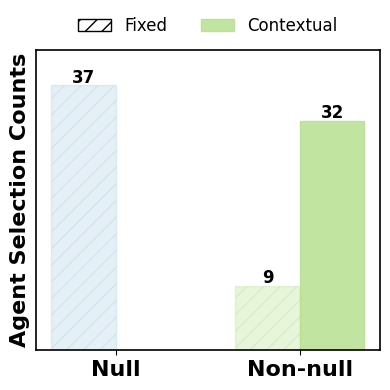

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Categories and data
categories = ['Null', 'Non-null']
heights = [[37, 0], [9, 32]]  # Null has one bar, non-null has two bars
colors = [['#a6cee3', '#a6cee3'], ['#b2df8a', '#b2df8a']]  # base colors
hatches = [['//', None], ['//', None]]  # Null bar and first non-null bar have hatches
alphas = [[0.3, 0], [0.3, 0.8]]  # Reduce opacity

# X positions
x = np.arange(len(categories))
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(4, 4))

# Plot bars and annotate heights
for i in range(len(categories)):
    for j in range(len(heights[i])):
        if heights[i][j] > 0:
            bar = ax.bar(
                x[i] + j*width - width/2, 
                heights[i][j], 
                width=width,
                color=colors[i][j], 
                alpha=alphas[i][j], 
                hatch=hatches[i][j], 
                edgecolor=colors[i][j]
            )
            # Annotate height
            ax.text(
                x[i] + j*width - width/2, 
                heights[i][j]-0.15,  # slightly above the bar
                str(heights[i][j]), 
                ha='center', va='bottom', fontsize=12, fontweight='bold'
            )

# Labels and styling
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=16, fontweight='bold')
ax.set_yticks([])
ax.set_ylabel('Agent Selection Counts', fontsize=16, fontweight='bold')

# Draw complete box around plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color('black')
ax.set_ylim(0, 42)
# Create custom legend
# Fixed Fees: only hatch visible, no fill color
fixed_fee_patch = mpatches.Patch(facecolor='white', hatch='//', edgecolor='black', label='Fixed')
# Contextual Fees: normal green bar
contextual_fee_patch = mpatches.Patch(facecolor='#b2df8a', alpha=0.8, edgecolor='#b2df8a', label='Contextual')

ax.legend(handles=[fixed_fee_patch, contextual_fee_patch], fontsize=12, frameon=False, loc='lower center', 
          bbox_to_anchor=(0.5, 1.0), ncol=3)
plt.tight_layout()
plt.savefig("count.pdf", format="pdf", bbox_inches='tight')
plt.show()


In [11]:
import numpy as np
from scipy.stats import beta

# Number of agents
num_nonnull = 50
num_null = 1000

# Sample bids
bids_nonnull = beta.rvs(4, 6, size=num_nonnull, random_state=42)
bids_null = beta.rvs(6, 4, size=num_null, random_state=42)

# Merge and sort
all_bids = np.concatenate([bids_nonnull, bids_null])
all_bids_sorted = np.sort(all_bids)

# Reserve price for selecting top 1000 participants (1001st highest bid)
reserve_index = 1000  # zero-indexed
reserve_price = all_bids_sorted[-reserve_index]
print("Reserve price:", reserve_price)

# Count how many selected agents are null and non-null
selected_bids = all_bids_sorted[-1000:]  # top 1000 bids

# Boolean masks for selection
selected_nonnull = np.isin(selected_bids, bids_nonnull)
selected_null = np.isin(selected_bids, bids_null)

num_selected_nonnull = np.sum(selected_nonnull)
num_selected_null = np.sum(selected_null)

print("Selected non-null:", num_selected_nonnull)
print("Selected null:", num_selected_null)

# Count how many sampled agents have bids > 0.5
nonnull_above_0_5 = np.sum(bids_nonnull > 0.5)
null_above_0_5 = np.sum(bids_null > 0.5)

print("Non-null agents with bids > 0.5:", nonnull_above_0_5)
print("Null agents with bids > 0.5:", null_above_0_5)

Reserve price: 0.32374111131923866
Selected non-null: 32
Selected null: 968
Non-null agents with bids > 0.5: 9
Null agents with bids > 0.5: 740


In [9]:
bids_nonnull

array([0.46807528, 0.38694857, 0.49677124, 0.2868421 , 0.65113249,
       0.24114833, 0.58486859, 0.31426851, 0.34490255, 0.5096277 ,
       0.62915042, 0.21320735, 0.46414796, 0.40924272, 0.24970126,
       0.47392846, 0.2576928 , 0.42364179, 0.31511531, 0.35032964,
       0.36352978, 0.50796682, 0.25953056, 0.43489999, 0.33210585,
       0.33808931, 0.46835349, 0.31720923, 0.33504281, 0.40317903,
       0.24940048, 0.33495485, 0.43234082, 0.16197247, 0.2153391 ,
       0.34038713, 0.45231224, 0.70593663, 0.31967873, 0.19657315,
       0.17540251, 0.32374111, 0.6293732 , 0.18292043, 0.35109133,
       0.42637477, 0.28714232, 0.5075336 , 0.55372147, 0.21302727])

In [10]:
selected_bids

array([0.32374111, 0.32387451, 0.32442256, 0.32807394, 0.32945697,
       0.32947652, 0.33145796, 0.33210585, 0.33297868, 0.33495485,
       0.33504281, 0.33597378, 0.33704497, 0.33717654, 0.33739076,
       0.33808931, 0.33854266, 0.33923164, 0.34038713, 0.34052403,
       0.34490255, 0.34521102, 0.34779903, 0.34941859, 0.35032964,
       0.35045764, 0.35109133, 0.35156868, 0.35206343, 0.35523759,
       0.35524735, 0.35613909, 0.35900259, 0.36032895, 0.36220661,
       0.36352978, 0.36386421, 0.36437176, 0.36615702, 0.3673713 ,
       0.36745887, 0.36752315, 0.36866732, 0.36962423, 0.37448106,
       0.37506172, 0.37628948, 0.3772284 , 0.37728421, 0.3779989 ,
       0.3789109 , 0.38000595, 0.38058064, 0.38113873, 0.38333184,
       0.38370844, 0.38473333, 0.3861317 , 0.38670533, 0.38694857,
       0.38723617, 0.38961672, 0.39085693, 0.39094919, 0.39099604,
       0.39135266, 0.39182528, 0.39217019, 0.39240646, 0.39529077,
       0.39541122, 0.39664352, 0.39722994, 0.39750602, 0.39808